In [36]:
import os 
import sys
import re 
import numpy as np
import agilent_loader as ag
import matplotlib.pyplot as plt

folder = "4.05.2023"

files_in_folder = [f for f in os.listdir(folder) if '.mi' in f]


for filename in files_in_folder:
	# Generate the new filename by replacing spaces with underscores and removing "@"
	new_filename = filename.replace(" ", "_").replace("@", "")
	
	# Construct the full old and new file paths
	old_file_path = os.path.join(folder, filename)
	new_file_path = os.path.join(folder, new_filename)
	
	# Rename the file
	os.rename(old_file_path, new_file_path)



print(f" Found {len(files_in_folder)} files in {folder}")
print(files_in_folder)

 Found 5229 files in 4.05.2023
['friction_8v_8lines_00000.mi', 'friction_8v_8lines_00001.mi', 'friction_8v_8lines_00002.mi', 'friction_8v_8lines_00003.mi', 'friction_8v_8lines_00004.mi', 'friction_8v_8lines_00005.mi', 'friction_8v_8lines_00006.mi', 'friction_8v_8lines_00007.mi', 'friction_8v_8lines_00008.mi', 'friction_8v_8lines_00009.mi', 'friction_8v_8lines_00010.mi', 'friction_8v_8lines_00011.mi', 'friction_8v_8lines_00012.mi', 'friction_8v_8lines_00013.mi', 'friction_8v_8lines_00014.mi', 'friction_8v_8lines_00015.mi', 'friction_8v_8lines_00016.mi', 'friction_8v_8lines_00017.mi', 'friction_8v_8lines_00018.mi', 'friction_8v_8lines_00019.mi', 'friction_8v_8lines_00020.mi', 'friction_8v_8lines_00021.mi', 'friction_8v_8lines_00022.mi', 'friction_8v_8lines_00023.mi', 'friction_8v_8lines_00024.mi', 'friction_8v_8lines_00025.mi', 'friction_8v_8lines_00026.mi', 'friction_8v_8lines_00027.mi', 'friction_8v_8lines_00028.mi', 'friction_8v_8lines_00029.mi', 'friction_8v_8lines_00030.mi', 'fricti

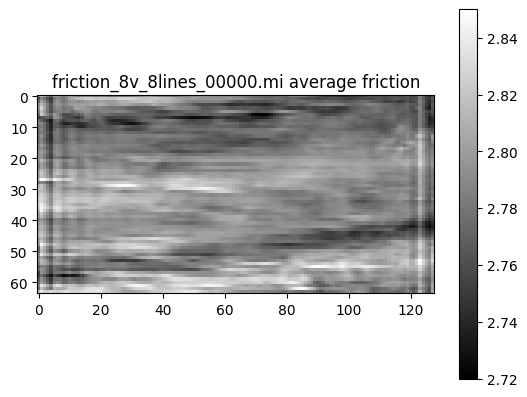

(2.0, 4.0)

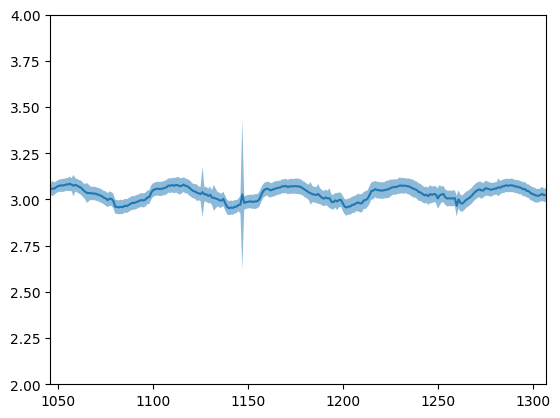

In [35]:
Cof_for_runs=np.zeros(len(files_in_folder))
Cof_for_runs_std=np.zeros(len(files_in_folder))
ii=0


for file_path in files_in_folder:
	
	file=ag.load_mi(folder+"\\"+file_path)	
	friction_arrays=[]

	for buffer in file.buffers:
		
		if buffer.bufferLabel == "Friction":
			friction_arrays.append(buffer.data)
			
	if len(friction_arrays) == 2:
		averaged_friction = (abs(friction_arrays[0]) + abs(friction_arrays[1])) / 2

		friction_std=np.std(averaged_friction)
		friction_mean=np.mean(averaged_friction)
		Cof_for_runs[ii]=friction_mean
		Cof_for_runs_std[ii]=friction_std

	else:
		raise ValueError("Expected 2 friction arrays, got %d" % len(friction_arrays)+f" with file {file_path} ")

	if (ii==0):
		
		plt.imshow(averaged_friction,cmap='binary_r')
		plt.title(file_path+" average friction")
		plt.colorbar()
		plt.show()
		plt.clf()

	ii+=1


plt.plot(np.arange(len(Cof_for_runs)),Cof_for_runs)	
plt.fill_between(np.arange(len(Cof_for_runs)),Cof_for_runs-Cof_for_runs_std,Cof_for_runs+Cof_for_runs_std,alpha=0.5)
plt.xlim(len(Cof_for_runs)/5,len(Cof_for_runs)/4)
plt.ylim(2,4)

